# Data analysis and making some machine learning models based on our data simulation.


In [274]:
# Importing essential libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For DBSCAN clustering and evaluation
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# For mapping clusters to ground truth
from scipy.optimize import linear_sum_assignment

# For handling warnings
import warnings
warnings.filterwarnings('ignore')

# Display settings
%matplotlib inline
sns.set(style="whitegrid")


In [275]:
boid = pd.read_csv("data/boid_simulation_datav2.csv", dtype={'boid_id': 'int',
                                                               'color': 'str',
                                                               'flock_id': 'int', 
                                                               'frame': 'int', 
                                                               'vx': 'float32', 
                                                               'vy': 'float32',
                                                               'x': 'float32', 
                                                               'y': 'float32'}
                  )
boid

,boid_id,color,flock_id,frame,vx,vy,x,y
0,0,#46cefb,1,0,0.280019,-1.901190,134.572067,82.312866
1,1,#46cefb,1,0,1.315824,-3.014671,125.416580,114.490341
2,2,#46cefb,1,0,-2.668383,2.362984,98.089973,126.322273
3,3,#46cefb,1,0,-1.591503,-0.080129,99.256859,115.117630
4,4,#46cefb,1,0,3.329183,0.653950,100.603447,93.246277
...,...,...,...,...,...,...,...,...
55675,55,#ccf849,2,927,-3.156764,1.929136,52.779011,259.567627
55676,56,#ccf849,2,927,-2.470615,1.212264,93.097069,274.738647
55677,57,#ccf849,2,927,-3.318367,1.045513,96.449875,242.166382
55678,58,#ccf849,2,927,-2.386250,1.800061,87.205238,223.686813


In [276]:
# Check unique frames
unique_frames = boid['frame'].nunique()
print(f"Total number of frames: {unique_frames}")


Total number of frames: 928


In [277]:
# Check the shape of the data
print(f"Data shape: {boid.shape}")

# Summary statistics
boid.describe()

# Check for missing values
boid.isnull().sum()


Data shape: (55680, 8)


boid_id     0
color       0
flock_id    0
frame       0
vx          0
vy          0
x           0
y           0
dtype: int64

In [278]:
def map_clusters_to_flocks(true_labels, cluster_labels):
    """
    Maps DBSCAN cluster labels to true flock IDs using the Hungarian algorithm.
    
    Parameters:
    - true_labels: array-like of shape (n_samples,)
    - cluster_labels: array-like of shape (n_samples,)
    
    Returns:
    - mapping: dict where keys are cluster labels and values are flock IDs
    """
    from sklearn.metrics import confusion_matrix
    
    # Get unique labels
    unique_clusters = set(cluster_labels)
    unique_flocks = set(true_labels)
    
    # Remove noise label (-1) from clusters if present
    unique_clusters.discard(-1)
    
    # Create confusion matrix
    matrix = confusion_matrix(true_labels, cluster_labels, labels=list(unique_flocks), sample_weight=None)
    
    # Apply Hungarian algorithm to maximize matching
    row_ind, col_ind = linear_sum_assignment(-matrix)
    
    # Create mapping
    mapping = {}
    for flock, cluster in zip(row_ind, col_ind):
        mapping[cluster] = flock
    
    return mapping


In [279]:
def calculate_metrics(true_labels, predicted_labels):
    """
    Calculates ARI and NMI between true and predicted labels.
    
    Parameters:
    - true_labels: array-like of shape (n_samples,)
    - predicted_labels: array-like of shape (n_samples,)
    
    Returns:
    - ari: Adjusted Rand Index
    - nmi: Normalized Mutual Information
    """
    ari = adjusted_rand_score(true_labels, predicted_labels)
    nmi = normalized_mutual_info_score(true_labels, predicted_labels)
    return ari, nmi


In [280]:
def assign_colors(true_labels, predicted_labels, mapping):
    """
    Assigns colors to boids based on correct or incorrect cluster assignments.
    
    Parameters:
    - true_labels: array-like of shape (n_samples,)
    - predicted_labels: array-like of shape (n_samples,)
    - mapping: dict mapping cluster labels to flock IDs
    
    Returns:
    - colors: list of colors for each boid ('blue' for correct, 'red' for incorrect, 'grey' for noise)
    """
    colors = []
    for true, pred in zip(true_labels, predicted_labels):
        if pred == -1:
            colors.append('grey')  # Noise
        elif mapping.get(pred, -2) == true:
            colors.append('blue')   # Correct
        else:
            colors.append('red')    # Incorrect
    return colors


In [281]:
# Initialize lists to store metrics over time
frame_list = []
ari_list = []
nmi_list = []


In [282]:
# Get all unique frames sorted
all_frames = sorted(boid['frame'].unique())

# Select a subset of frames to analyze (for demonstration purposes)
# You can adjust this to analyze all frames or specific frames
frames_to_analyze = all_frames[:]  # Analyzing the first 100 frames


In [283]:
for frame in frames_to_analyze:
    # Extract data for the current frame
    frame_data = boid[boid['frame'] == frame].reset_index(drop=True)
    
    # Features for clustering
    X = frame_data[['x', 'y']].values  # You can include 'vx' and 'vy' if desired
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply DBSCAN
    db = DBSCAN(eps=0.5, min_samples=5)  # Adjust parameters as needed
    db.fit(X_scaled)
    labels = db.labels_
    
    # Ground truth labels
    true_labels = frame_data['flock_id'].values
    
    # Map clusters to flocks
    mapping = map_clusters_to_flocks(true_labels, labels)
    
    # Calculate metrics
    ari, nmi = calculate_metrics(true_labels, labels)
    
    # Assign colors based on correctness
    colors = assign_colors(true_labels, labels, mapping)
    
    # Store metrics
    frame_list.append(frame)
    ari_list.append(ari)
    nmi_list.append(nmi)

    # Optionally, visualize each frame
    # Uncomment the following block to visualize
    #plt.figure(figsize=(8,6))
    #sns.scatterplot(x=frame_data['x'], y=frame_data['y'], 
    #                hue=colors, palette=['blue', 'red', 'grey'],
     #               legend='full', s=30, edgecolor='k', alpha=0.7)
    #plt.title(f'DBSCAN Clustering for Frame {frame} - ARI: {ari:.2f}, NMI: {nmi:.2f}')
    #plt.xlabel('X Position')
    #plt.ylabel('Y Position')
    #plt.legend(title='Assignment', labels=['Correct', 'Incorrect', 'Noise'])
    #plt.show()
###

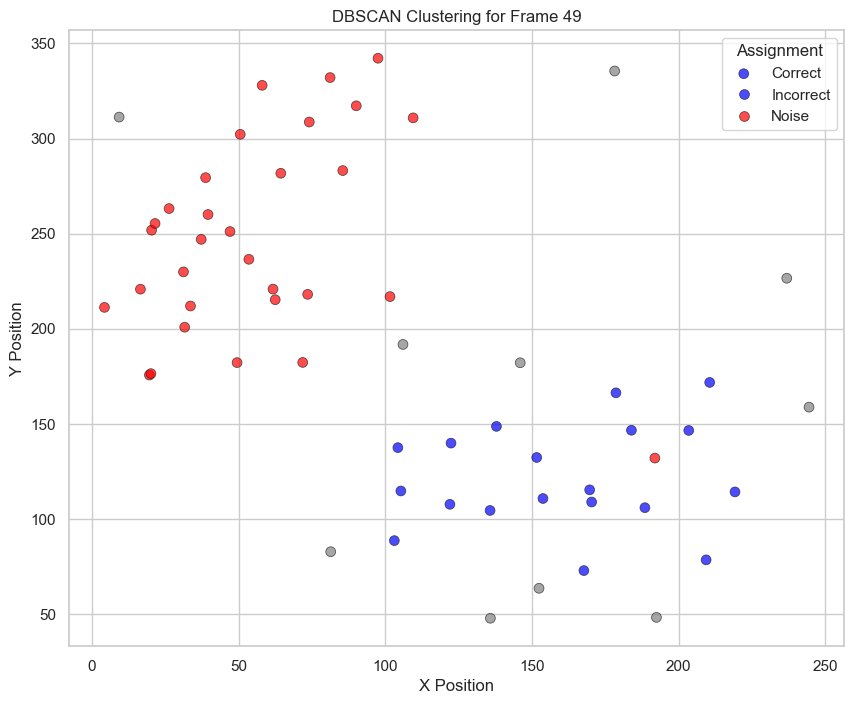

In [284]:
# Select a specific frame to visualize
visual_frame = frames_to_analyze[49]  # For example, the 50th frame in frames_to_analyze

# Extract data for the selected frame
frame_data = boid[boid['frame'] == visual_frame].reset_index(drop=True)

# Features for clustering
X = frame_data[['x', 'y']].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply DBSCAN
db = DBSCAN(eps=0.5, min_samples=5)
db.fit(X_scaled)
labels = db.labels_

# Ground truth labels
true_labels = frame_data['flock_id'].values

# Map clusters to flocks
mapping = map_clusters_to_flocks(true_labels, labels)

# Assign colors based on correctness
colors = assign_colors(true_labels, labels, mapping)

# Visualization
plt.figure(figsize=(10,8))
sns.scatterplot(x=frame_data['x'], y=frame_data['y'], 
                hue=colors, palette=['blue', 'red', 'grey'],
                legend='full', s=50, edgecolor='k', alpha=0.7)
plt.title(f'DBSCAN Clustering for Frame {visual_frame}')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend(title='Assignment', labels=['Correct', 'Incorrect', 'Noise'])
plt.show()


In [285]:
# Create a DataFrame for metrics
metrics_df = pd.DataFrame({
    'frame': frame_list,
    'ARI': ari_list,
    'NMI': nmi_list
})

# Display the first few rows
metrics_df.head()


,frame,ARI,NMI
0,0,0.659065,0.668284
1,1,0.582351,0.613633
2,2,0.728655,0.719402
3,3,0.728655,0.719402
4,4,0.676168,0.687027


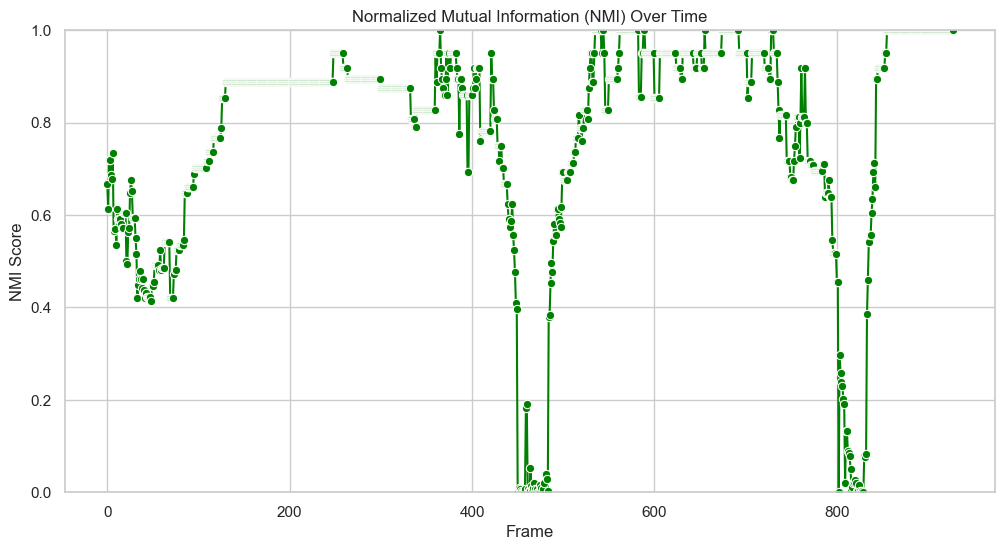

In [286]:
plt.figure(figsize=(12,6))
sns.lineplot(data=metrics_df, x='frame', y='NMI', marker='o', color='green')
plt.title('Normalized Mutual Information (NMI) Over Time')
plt.xlabel('Frame')
plt.ylabel('NMI Score')
plt.ylim(0, 1)
plt.show()


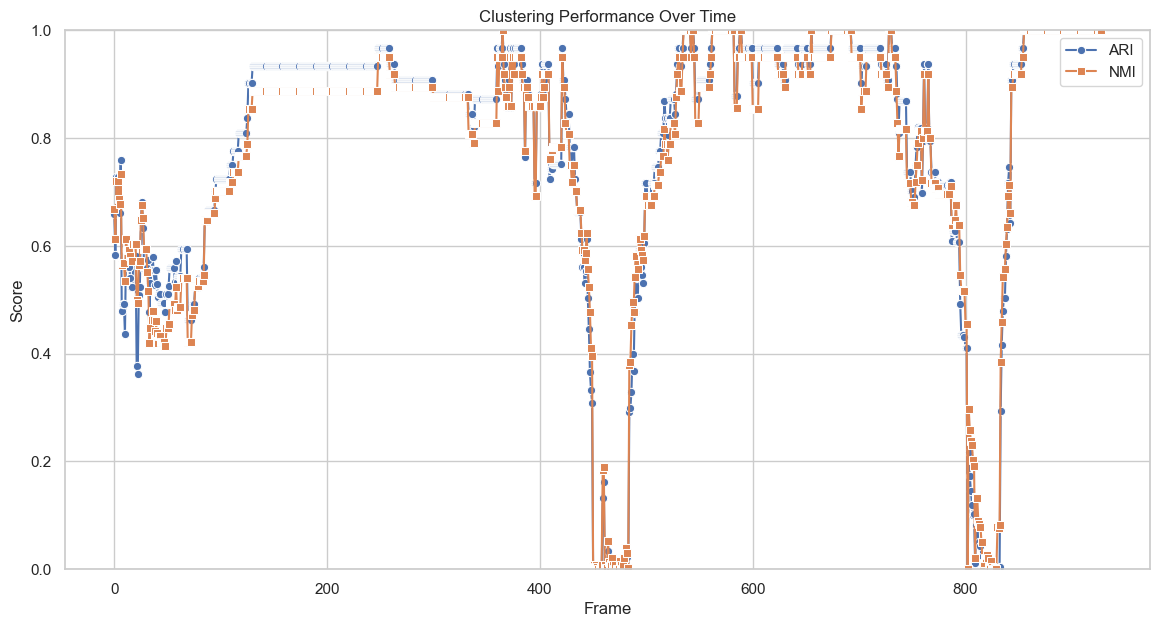

In [287]:
plt.figure(figsize=(14,7))
sns.lineplot(data=metrics_df, x='frame', y='ARI', marker='o', label='ARI')
sns.lineplot(data=metrics_df, x='frame', y='NMI', marker='s', label='NMI')
plt.title('Clustering Performance Over Time')
plt.xlabel('Frame')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend()
plt.show()


In [288]:
# Extract features for clustering: position and velocity
X = frame_data[['x', 'y', 'vx', 'vy']].values
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [289]:
for frame in frames_to_analyze:
    # Extract data for the current frame
    frame_data = boid[boid['frame'] == frame].reset_index(drop=True)
    
    # Features for clustering: position and velocity
    X = frame_data[['x', 'y', 'vx', 'vy']].values
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply DBSCAN
    db = DBSCAN(eps=0.5, min_samples=5)  # Adjust parameters as needed
    db.fit(X_scaled)
    labels = db.labels_
    
    # Ground truth labels
    true_labels = frame_data['flock_id'].values
    
    # Map clusters to flocks
    mapping = map_clusters_to_flocks(true_labels, labels)
    
    # Calculate metrics
    ari, nmi = calculate_metrics(true_labels, labels)
    
    # Assign colors based on correctness
    colors = assign_colors(true_labels, labels, mapping)
    
    # Store metrics
    frame_list.append(frame)
    ari_list.append(ari)
    nmi_list.append(nmi)
    
    # Optionally, visualize each frame
    # Uncomment the following block to visualize
   # plt.figure(figsize=(8,6))
   # sns.scatterplot(x=frame_data['x'], y=frame_data['y'], 
    #                hue=colors, palette=['blue', 'red', 'grey'],
    #                legend='full', s=30, edgecolor='k', alpha=0.7)
    #plt.title(f'DBSCAN Clustering for Frame {frame} - ARI: {ari:.2f}, NMI: {nmi:.2f}')
    #plt.xlabel('X Position')
    #plt.ylabel('Y Position')
    #plt.legend(title='Assignment', labels=['Correct', 'Incorrect', 'Noise'])
    #plt.show()


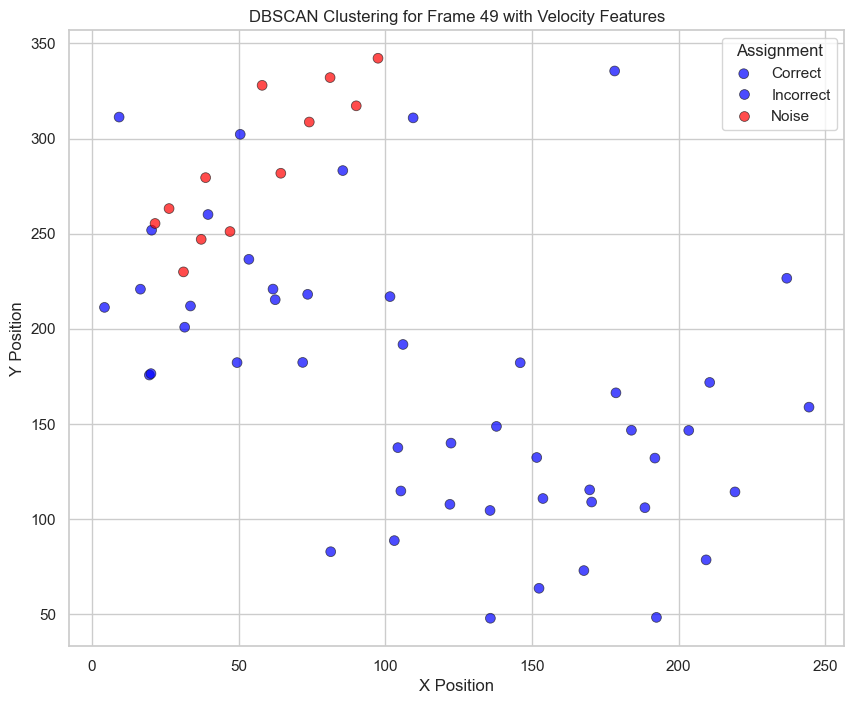

In [290]:
# Select a specific frame to visualize
visual_frame = frames_to_analyze[49]  # For example, the 50th frame in frames_to_analyze

# Extract data for the selected frame
frame_data = boid[boid['frame'] == visual_frame].reset_index(drop=True)

# Features for clustering: position and velocity
X = frame_data[['x', 'y', 'vx', 'vy']].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply DBSCAN
db = DBSCAN(eps=0.5, min_samples=5)
db.fit(X_scaled)
labels = db.labels_

# Ground truth labels
true_labels = frame_data['flock_id'].values

# Map clusters to flocks
mapping = map_clusters_to_flocks(true_labels, labels)

# Assign colors based on correctness
colors = assign_colors(true_labels, labels, mapping)

# Visualization
plt.figure(figsize=(10,8))
sns.scatterplot(x=frame_data['x'], y=frame_data['y'], 
                hue=colors, palette=['blue', 'red', 'grey'],
                legend='full', s=50, edgecolor='k', alpha=0.7)
plt.title(f'DBSCAN Clustering for Frame {visual_frame} with Velocity Features')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.legend(title='Assignment', labels=['Correct', 'Incorrect', 'Noise'])
plt.show()


In [291]:
# Create a DataFrame for metrics
metrics_df = pd.DataFrame({
    'frame': frame_list,
    'ARI': ari_list,
    'NMI': nmi_list
})

# Display the first few rows
metrics_df.head()



,frame,ARI,NMI
0,0,0.659065,0.668284
1,1,0.582351,0.613633
2,2,0.728655,0.719402
3,3,0.728655,0.719402
4,4,0.676168,0.687027


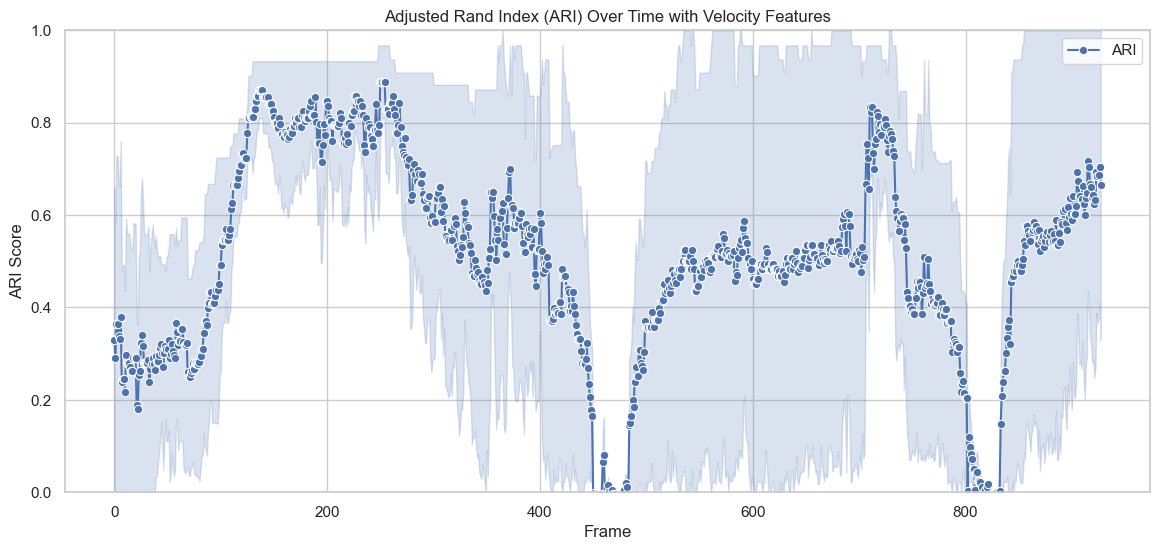

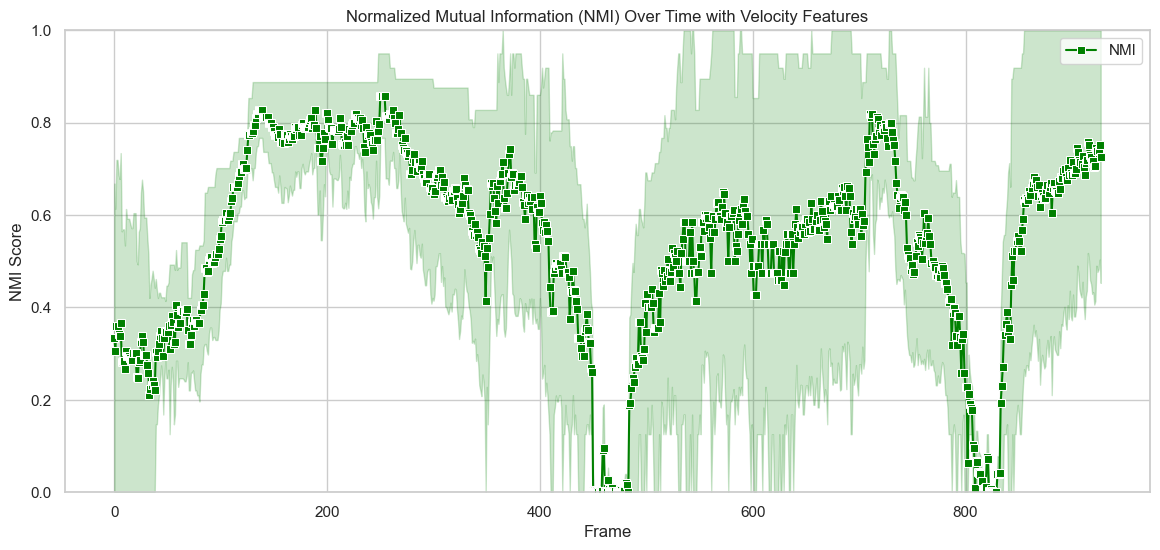

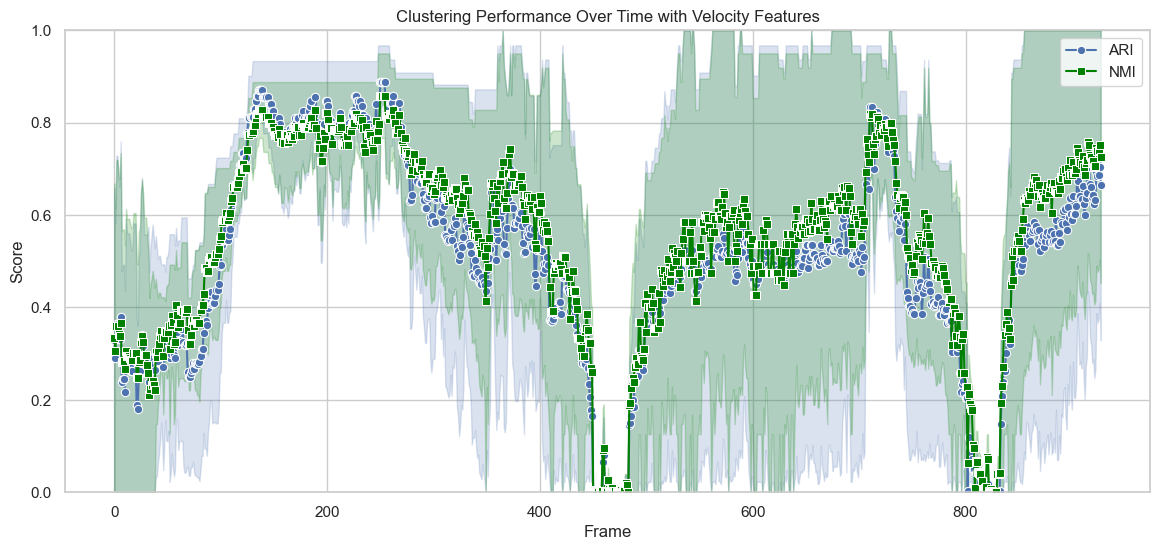

In [292]:
# Plot ARI over time
plt.figure(figsize=(14,6))
sns.lineplot(data=metrics_df, x='frame', y='ARI', label='ARI', marker='o')
plt.title('Adjusted Rand Index (ARI) Over Time with Velocity Features')
plt.xlabel('Frame')
plt.ylabel('ARI Score')
plt.ylim(0, 1)
plt.legend()
plt.show()

# Plot NMI over time
plt.figure(figsize=(14,6))
sns.lineplot(data=metrics_df, x='frame', y='NMI', label='NMI', color='green', marker='s')
plt.title('Normalized Mutual Information (NMI) Over Time with Velocity Features')
plt.xlabel('Frame')
plt.ylabel('NMI Score')
plt.ylim(0, 1)
plt.legend()
plt.show()

# Combined Plot
plt.figure(figsize=(14,6))
sns.lineplot(data=metrics_df, x='frame', y='ARI', label='ARI', marker='o')
sns.lineplot(data=metrics_df, x='frame', y='NMI', label='NMI', color='green', marker='s')
plt.title('Clustering Performance Over Time with Velocity Features')
plt.xlabel('Frame')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend()
plt.show()


In [293]:
def map_clusters_to_flocks(true_labels, cluster_labels):
    """
    Maps DBSCAN cluster labels to true flock IDs using the Hungarian algorithm.
    
    Parameters:
    - true_labels: array-like of shape (n_samples,)
    - cluster_labels: array-like of shape (n_samples,)
    
    Returns:
    - mapping: dict where keys are cluster labels and values are flock IDs
    """
    from sklearn.metrics import confusion_matrix
    
    # Get unique labels
    unique_clusters = set(cluster_labels)
    unique_flocks = set(true_labels)
    
    # Remove noise label (-1) from clusters if present
    unique_clusters.discard(-1)
    
    # Create confusion matrix
    matrix = confusion_matrix(true_labels, cluster_labels, labels=list(unique_flocks), sample_weight=None)
    
    # Apply Hungarian algorithm to maximize matching
    row_ind, col_ind = linear_sum_assignment(-matrix)
    
    # Create mapping
    mapping = {}
    for flock, cluster in zip(row_ind, col_ind):
        mapping[cluster] = flock
    
    return mapping


In [294]:
def calculate_metrics(true_labels, predicted_labels):
    """
    Calculates ARI and NMI between true and predicted labels.
    
    Parameters:
    - true_labels: array-like of shape (n_samples,)
    - predicted_labels: array-like of shape (n_samples,)
    
    Returns:
    - ari: Adjusted Rand Index
    - nmi: Normalized Mutual Information
    """
    ari = adjusted_rand_score(true_labels, predicted_labels)
    nmi = normalized_mutual_info_score(true_labels, predicted_labels)
    return ari, nmi


In [295]:
def assign_colors(true_labels, predicted_labels, mapping):
    """
    Assigns colors to boids based on correct or incorrect cluster assignments.
    
    Parameters:
    - true_labels: array-like of shape (n_samples,)
    - predicted_labels: array-like of shape (n_samples,)
    - mapping: dict mapping cluster labels to flock IDs
    
    Returns:
    - colors: list of colors for each boid ('blue' for correct, 'red' for incorrect, 'grey' for noise)
    """
    colors = []
    for true, pred in zip(true_labels, predicted_labels):
        if pred == -1:
            colors.append('grey')  # Noise
        elif mapping.get(pred, -2) == true:
            colors.append('blue')   # Correct
        else:
            colors.append('red')    # Incorrect
    return colors


In [296]:
# Initialize lists to store metrics over time
frame_list = []
ari_list = []
nmi_list = []


In [297]:
# Define DBSCAN parameters
eps_value = 0.5
min_samples_value = 5


In [298]:
# Get all unique frames sorted
all_frames = sorted(boid['frame'].unique())

# Optionally, to reduce computation time, you can analyze a subset
# frames_to_analyze = all_frames[:100]  # For example, the first 100 frames
# For a full comparison, we'll analyze all frames
frames_to_analyze = all_frames

for frame in frames_to_analyze:
    # Extract data for the current frame
    frame_data = boid[boid['frame'] == frame].reset_index(drop=True)
    
    # Features for clustering: position and velocity
    X = frame_data[['x', 'y', 'vx', 'vy']].values
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply DBSCAN
    db = DBSCAN(eps=eps_value, min_samples=min_samples_value)
    db.fit(X_scaled)
    labels = db.labels_
    
    # Ground truth labels
    true_labels = frame_data['flock_id'].values
    
    # Map clusters to flocks
    mapping = map_clusters_to_flocks(true_labels, labels)
    
    # Calculate metrics
    ari, nmi = calculate_metrics(true_labels, labels)
    
    # Assign colors based on correctness
    colors = assign_colors(true_labels, labels, mapping)
    
    # Store metrics
    frame_list.append(frame)
    ari_list.append(ari)
    nmi_list.append(nmi)
    
    # Optional: Print progress every 100 frames
    if frame % 100 == 0:
        print(f"Processed frame {frame}/{all_frames[-1]}")


Processed frame 0/927
Processed frame 100/927
Processed frame 200/927
Processed frame 300/927
Processed frame 400/927
Processed frame 500/927
Processed frame 600/927
Processed frame 700/927
Processed frame 800/927
Processed frame 900/927


In [299]:
# Create a DataFrame for metrics
metrics_df = pd.DataFrame({
    'frame': frame_list,
    'ARI': ari_list,
    'NMI': nmi_list
})

# Display the first few rows
metrics_df.head()


,frame,ARI,NMI
0,0,0.0,0.0
1,1,0.0,0.0
2,2,0.0,0.0
3,3,0.0,0.0
4,4,0.0,0.0


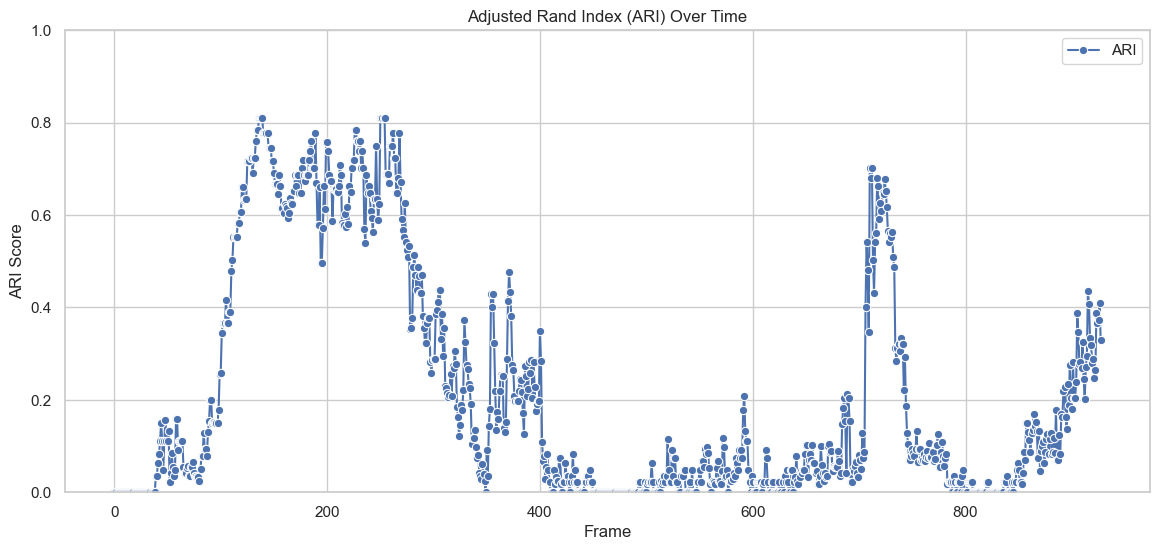

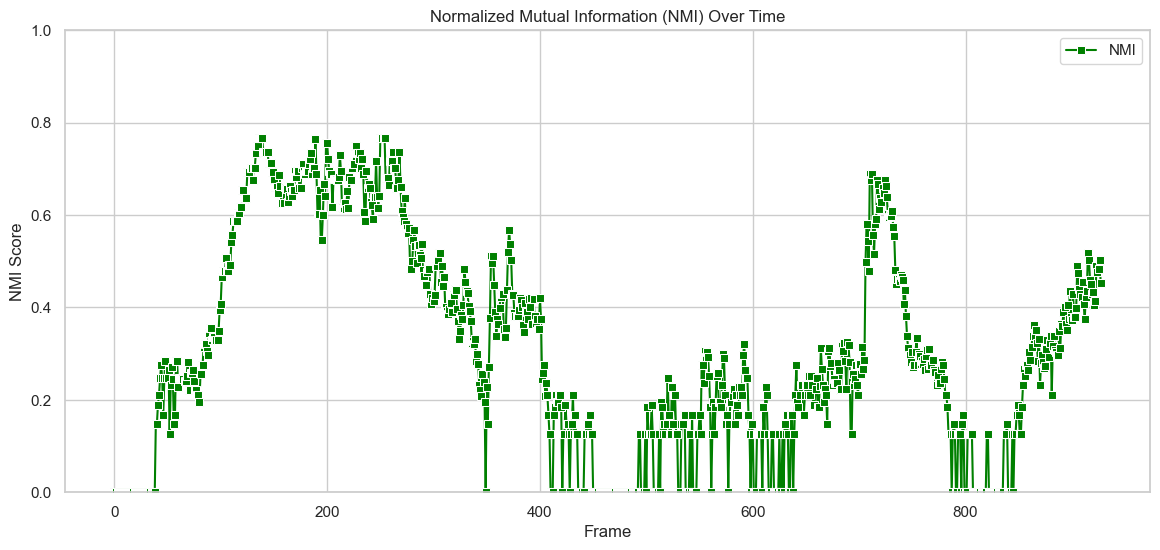

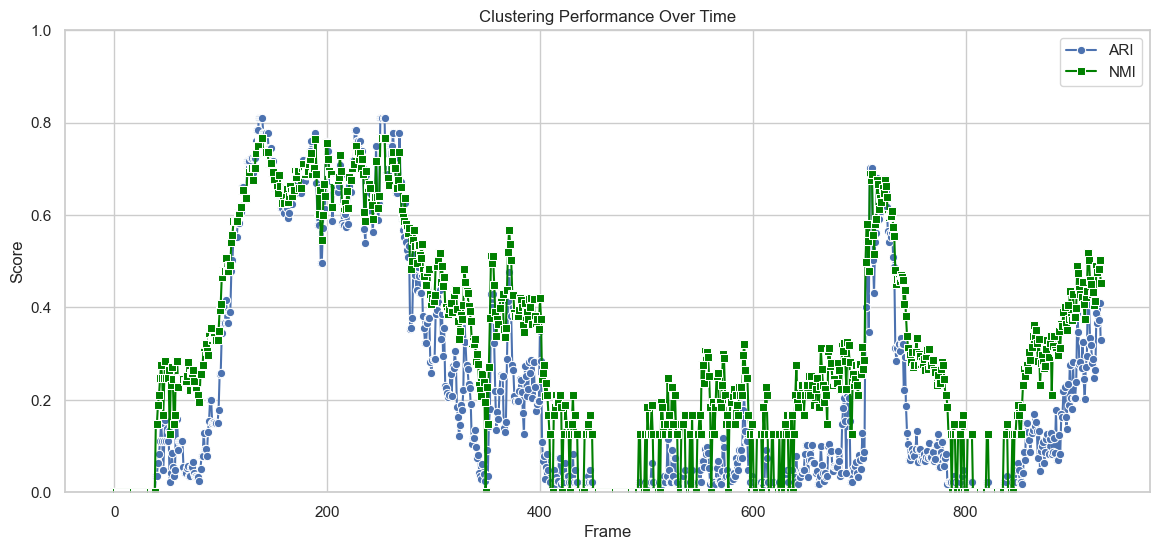

In [300]:
# Plot ARI over time
plt.figure(figsize=(14,6))
sns.lineplot(data=metrics_df, x='frame', y='ARI', label='ARI', marker='o')
plt.title('Adjusted Rand Index (ARI) Over Time')
plt.xlabel('Frame')
plt.ylabel('ARI Score')
plt.ylim(0, 1)
plt.legend()
plt.show()

# Plot NMI over time
plt.figure(figsize=(14,6))
sns.lineplot(data=metrics_df, x='frame', y='NMI', label='NMI', color='green', marker='s')
plt.title('Normalized Mutual Information (NMI) Over Time')
plt.xlabel('Frame')
plt.ylabel('NMI Score')
plt.ylim(0, 1)
plt.legend()
plt.show()

# Combined Plot
plt.figure(figsize=(14,6))
sns.lineplot(data=metrics_df, x='frame', y='ARI', label='ARI', marker='o')
sns.lineplot(data=metrics_df, x='frame', y='NMI', label='NMI', color='green', marker='s')
plt.title('Clustering Performance Over Time')
plt.xlabel('Frame')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend()
plt.show()


In [301]:
# Summary statistics for ARI
ari_summary = metrics_df['ARI'].describe()
print("ARI Summary:")
print(ari_summary)

# Summary statistics for NMI
nmi_summary = metrics_df['NMI'].describe()
print("\nNMI Summary:")
print(nmi_summary)


ARI Summary:
count    928.000000
mean       0.218299
std        0.253489
min        0.000000
25%        0.022717
50%        0.088253
75%        0.367180
max        0.809560
Name: ARI, dtype: float64

NMI Summary:
count    928.000000
mean       0.310753
std        0.232483
min        0.000000
25%        0.125625
50%        0.275763
75%        0.482038
max        0.767002
Name: NMI, dtype: float64


In [302]:
# Initialize containers for metrics
frame_list_pos = []
ari_list_pos = []
nmi_list_pos = []

# Define DBSCAN parameters
eps_value_pos = 0.5
min_samples_value_pos = 5

for frame in frames_to_analyze:
    # Extract data for the current frame
    frame_data = boid[boid['frame'] == frame].reset_index(drop=True)
    
    # Features for clustering: position only
    X = frame_data[['x', 'y']].values
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply DBSCAN
    db = DBSCAN(eps=eps_value_pos, min_samples=min_samples_value_pos)
    db.fit(X_scaled)
    labels = db.labels_
    
    # Ground truth labels
    true_labels = frame_data['flock_id'].values
    
    # Map clusters to flocks
    mapping = map_clusters_to_flocks(true_labels, labels)
    
    # Calculate metrics
    ari, nmi = calculate_metrics(true_labels, labels)
    
    # Store metrics
    frame_list_pos.append(frame)
    ari_list_pos.append(ari)
    nmi_list_pos.append(nmi)
    
    # Optional: Print progress every 100 frames
    if frame % 100 == 0:
        print(f"Processed frame {frame}/{all_frames[-1]} (Position Only)")


Processed frame 0/927 (Position Only)
Processed frame 100/927 (Position Only)
Processed frame 200/927 (Position Only)
Processed frame 300/927 (Position Only)
Processed frame 400/927 (Position Only)
Processed frame 500/927 (Position Only)
Processed frame 600/927 (Position Only)
Processed frame 700/927 (Position Only)
Processed frame 800/927 (Position Only)
Processed frame 900/927 (Position Only)


In [303]:
# Create DataFrames for both scenarios
metrics_df_pos = pd.DataFrame({
    'frame': frame_list_pos,
    'ARI_Position': ari_list_pos,
    'NMI_Position': nmi_list_pos
})

metrics_df_vel = pd.DataFrame({
    'frame': frame_list,
    'ARI_Velocity': ari_list,
    'NMI_Velocity': nmi_list
})

# Merge the two DataFrames on 'frame'
comparison_df = pd.merge(metrics_df_pos, metrics_df_vel, on='frame')

# Display the first few rows
comparison_df.head()


,frame,ARI_Position,NMI_Position,ARI_Velocity,NMI_Velocity
0,0,0.659065,0.668284,0.0,0.0
1,1,0.582351,0.613633,0.0,0.0
2,2,0.728655,0.719402,0.0,0.0
3,3,0.728655,0.719402,0.0,0.0
4,4,0.676168,0.687027,0.0,0.0


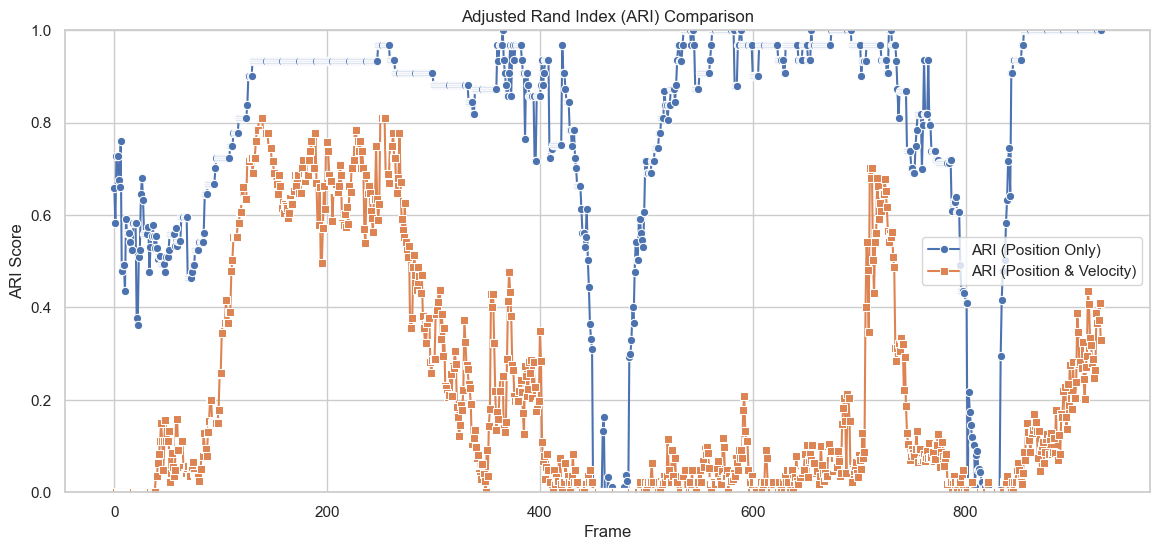

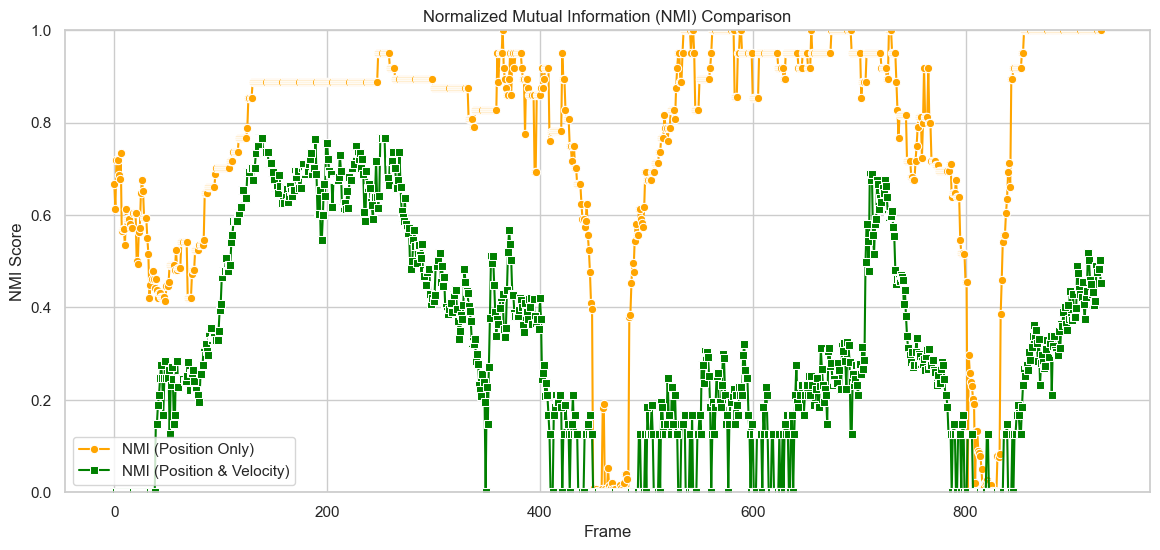

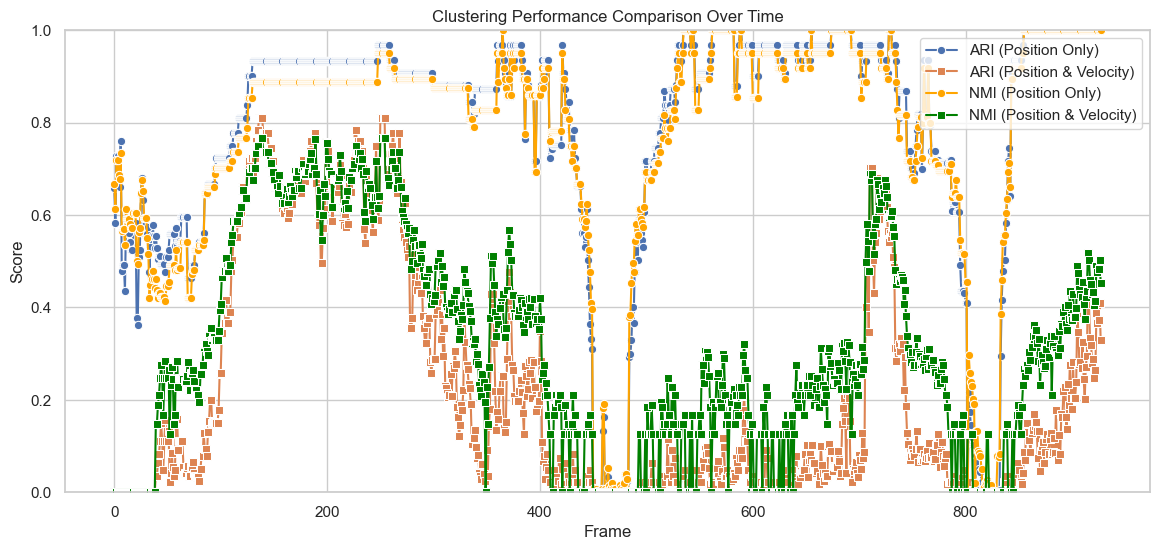

In [304]:
# Plot ARI Comparison
plt.figure(figsize=(14,6))
sns.lineplot(data=comparison_df, x='frame', y='ARI_Position', label='ARI (Position Only)', marker='o')
sns.lineplot(data=comparison_df, x='frame', y='ARI_Velocity', label='ARI (Position & Velocity)', marker='s')
plt.title('Adjusted Rand Index (ARI) Comparison')
plt.xlabel('Frame')
plt.ylabel('ARI Score')
plt.ylim(0, 1)
plt.legend()
plt.show()

# Plot NMI Comparison
plt.figure(figsize=(14,6))
sns.lineplot(data=comparison_df, x='frame', y='NMI_Position', label='NMI (Position Only)', color='orange', marker='o')
sns.lineplot(data=comparison_df, x='frame', y='NMI_Velocity', label='NMI (Position & Velocity)', color='green', marker='s')
plt.title('Normalized Mutual Information (NMI) Comparison')
plt.xlabel('Frame')
plt.ylabel('NMI Score')
plt.ylim(0, 1)
plt.legend()
plt.show()

# Combined ARI and NMI Comparison
plt.figure(figsize=(14,6))
sns.lineplot(data=comparison_df, x='frame', y='ARI_Position', label='ARI (Position Only)', marker='o')
sns.lineplot(data=comparison_df, x='frame', y='ARI_Velocity', label='ARI (Position & Velocity)', marker='s')
sns.lineplot(data=comparison_df, x='frame', y='NMI_Position', label='NMI (Position Only)', color='orange', marker='o')
sns.lineplot(data=comparison_df, x='frame', y='NMI_Velocity', label='NMI (Position & Velocity)', color='green', marker='s')
plt.title('Clustering Performance Comparison Over Time')
plt.xlabel('Frame')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend()
plt.show()


In [305]:
# Calculate mean and standard deviation for ARI
mean_ari_pos = metrics_df_pos['ARI_Position'].mean()
std_ari_pos = metrics_df_pos['ARI_Position'].std()

mean_ari_vel = metrics_df_vel['ARI_Velocity'].mean()
std_ari_vel = metrics_df_vel['ARI_Velocity'].std()

print(f"ARI (Position Only) - Mean: {mean_ari_pos:.4f}, Std: {std_ari_pos:.4f}")
print(f"ARI (Position & Velocity) - Mean: {mean_ari_vel:.4f}, Std: {std_ari_vel:.4f}\n")

# Calculate mean and standard deviation for NMI
mean_nmi_pos = metrics_df_pos['NMI_Position'].mean()
std_nmi_pos = metrics_df_pos['NMI_Position'].std()

mean_nmi_vel = metrics_df_vel['NMI_Velocity'].mean()
std_nmi_vel = metrics_df_vel['NMI_Velocity'].std()

print(f"NMI (Position Only) - Mean: {mean_nmi_pos:.4f}, Std: {std_nmi_pos:.4f}")
print(f"NMI (Position & Velocity) - Mean: {mean_nmi_vel:.4f}, Std: {std_nmi_vel:.4f}")


ARI (Position Only) - Mean: 0.7888, Std: 0.2632
ARI (Position & Velocity) - Mean: 0.2183, Std: 0.2535

NMI (Position Only) - Mean: 0.7760, Std: 0.2505
NMI (Position & Velocity) - Mean: 0.3108, Std: 0.2325


In [306]:
# First, install the st-dbscan package if available, or implement it manually.
# As of now, there's no widely-adopted Python package for ST-DBSCAN,
# so here's a simplified manual implementation.

import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

def st_dbscan(data, eps_space, eps_time, min_samples):
    """
    Space-Temporal DBSCAN clustering algorithm.
    
    Parameters:
    - data: pandas DataFrame containing 'x', 'y', 'frame' columns.
    - eps_space: Spatial distance threshold.
    - eps_time: Temporal distance threshold (number of frames).
    - min_samples: Minimum number of points to form a dense region.
    
    Returns:
    - cluster_labels: numpy array of cluster labels assigned to each point.
    """
    # Ensure required columns are present
    required_columns = ['x', 'y', 'frame']
    for col in required_columns:
        if col not in data.columns:
            raise ValueError(f"Column '{col}' is missing from the data.")

    # Sort data by frame to handle temporal aspects
    data_sorted = data.sort_values('frame').reset_index(drop=True)
    
    # Initialize cluster labels (-1 for noise)
    cluster_labels = np.full(data_sorted.shape[0], -1, dtype=int)
    
    # Initialize variables
    cluster_id = 0
    visited = np.zeros(data_sorted.shape[0], dtype=bool)
    
    # Precompute spatial coordinates for efficiency
    coordinates = data_sorted[['x', 'y']].values
    frames = data_sorted['frame'].values
    
    for idx in range(data_sorted.shape[0]):
        if visited[idx]:
            continue
        visited[idx] = True
        
        # Define the temporal window
        current_frame = frames[idx]
        min_frame = current_frame - eps_time
        max_frame = current_frame + eps_time
        
        # Find indices within temporal window
        temporal_mask = (frames >= min_frame) & (frames <= max_frame)
        temporal_indices = np.where(temporal_mask)[0]
        
        # Calculate spatial distances within temporal window
        spatial_diff = coordinates[temporal_indices] - coordinates[idx]
        spatial_distances = np.linalg.norm(spatial_diff, axis=1)
        
        # Find neighbors within spatial threshold
        neighbors = temporal_indices[spatial_distances <= eps_space].tolist()
        
        if len(neighbors) < min_samples:
            cluster_labels[idx] = -1  # Noise
        else:
            # Assign cluster ID
            cluster_labels[idx] = cluster_id
            seeds = neighbors.copy()
            
            while seeds:
                current_seed = seeds.pop(0)
                if not visited[current_seed]:
                    visited[current_seed] = True
                    
                    # Define temporal window for the seed
                    seed_frame = frames[current_seed]
                    min_seed_frame = seed_frame - eps_time
                    max_seed_frame = seed_frame + eps_time
                    
                    # Find indices within seed's temporal window
                    seed_temporal_mask = (frames >= min_seed_frame) & (frames <= max_seed_frame)
                    seed_temporal_indices = np.where(seed_temporal_mask)[0]
                    
                    # Calculate spatial distances within seed's temporal window
                    seed_spatial_diff = coordinates[seed_temporal_indices] - coordinates[current_seed]
                    seed_spatial_distances = np.linalg.norm(seed_spatial_diff, axis=1)
                    
                    # Find seed's neighbors within spatial threshold
                    seed_neighbors = seed_temporal_indices[seed_spatial_distances <= eps_space].tolist()
                    
                    if len(seed_neighbors) >= min_samples:
                        seeds.extend(seed_neighbors)
                
                # Assign cluster ID if the point is not yet assigned
                if cluster_labels[current_seed] == -1:
                    cluster_labels[current_seed] = cluster_id
            
            # Increment cluster ID for the next cluster
            cluster_id += 1
    
    return cluster_labels


In [307]:
# Define clustering parameters
eps_space = 25    # Adjust based on your simulation's scale
eps_time = 1      # Number of frames to consider as temporal neighbors
min_samples = 5   # Minimum number of points to form a cluster

# Initialize containers for metrics
frame_list_st = []
ari_list_st = []
nmi_list_st = []

# Get all unique frames sorted
all_frames = sorted(boid['frame'].unique())

for frame in all_frames:
    # Extract data for the current frame
    frame_data = boid[boid['frame'] == frame].reset_index(drop=True)
    
    # Apply ST-DBSCAN
    cluster_labels_st = st_dbscan(frame_data, eps_space, eps_time, min_samples)
    
    # Assign cluster labels to the main DataFrame
    boid.loc[boid['frame'] == frame, 'ST_DBSCAN_cluster'] = cluster_labels_st
    
    # Ground truth labels
    true_labels = frame_data['flock_id'].values
    
    # Calculate metrics only if there are clusters formed
    if len(set(cluster_labels_st)) > 1:  # More than one cluster (including noise)
        # Exclude noise for mapping
        mask = cluster_labels_st != -1
        if np.sum(mask) > 0:
            mapped_labels = map_clusters_to_flocks(true_labels[mask], cluster_labels_st[mask])
            # Reassign cluster labels based on mapping
            predicted_labels = np.array([mapped_labels.get(label, -1) for label in cluster_labels_st])
        else:
            predicted_labels = cluster_labels_st  # All noise
    else:
        predicted_labels = cluster_labels_st  # Single cluster or all noise
    
    # Calculate metrics
    ari, nmi = calculate_metrics(true_labels, predicted_labels)
    
    # Store metrics
    frame_list_st.append(frame)
    ari_list_st.append(ari)
    nmi_list_st.append(nmi)
    
    # Optional: Print progress every 100 frames
    if frame % 100 == 0:
        print(f"Processed frame {frame}/{all_frames[-1]} with ST-DBSCAN")

# Create a DataFrame for metrics
metrics_df_st = pd.DataFrame({
    'frame': frame_list_st,
    'ARI_ST_DBSCAN': ari_list_st,
    'NMI_ST_DBSCAN': nmi_list_st
})

# Display the first few rows of metrics
metrics_df_st.head()


Processed frame 0/927 with ST-DBSCAN
Processed frame 100/927 with ST-DBSCAN
Processed frame 200/927 with ST-DBSCAN
Processed frame 300/927 with ST-DBSCAN
Processed frame 400/927 with ST-DBSCAN
Processed frame 500/927 with ST-DBSCAN
Processed frame 600/927 with ST-DBSCAN
Processed frame 700/927 with ST-DBSCAN
Processed frame 800/927 with ST-DBSCAN
Processed frame 900/927 with ST-DBSCAN


,frame,ARI_ST_DBSCAN,NMI_ST_DBSCAN
0,0,0.606508,0.508839
1,1,0.582558,0.493562
2,2,0.702129,0.633451
3,3,0.667998,0.570476
4,4,0.667998,0.570476


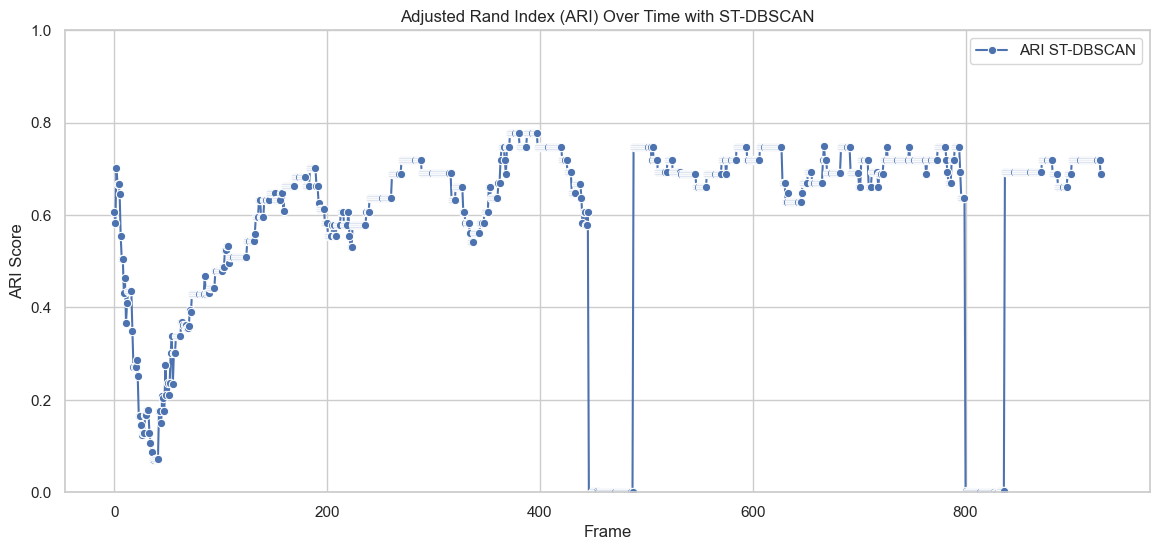

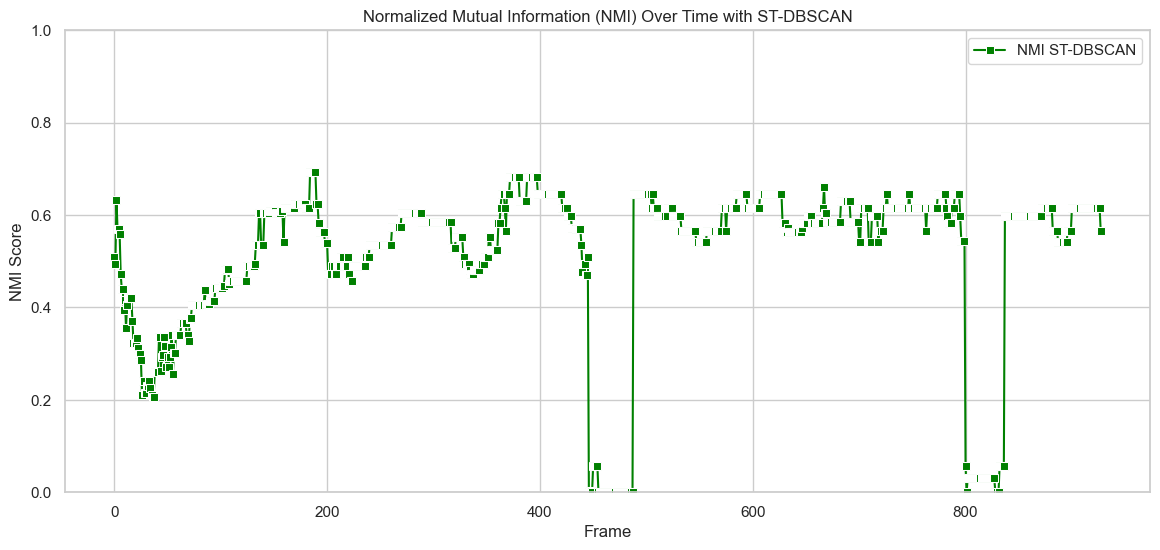

In [308]:
# Plot ARI over time
plt.figure(figsize=(14,6))
sns.lineplot(data=metrics_df_st, x='frame', y='ARI_ST_DBSCAN', label='ARI ST-DBSCAN', marker='o')
plt.title('Adjusted Rand Index (ARI) Over Time with ST-DBSCAN')
plt.xlabel('Frame')
plt.ylabel('ARI Score')
plt.ylim(0, 1)
plt.legend()
plt.show()

# Plot NMI over time
plt.figure(figsize=(14,6))
sns.lineplot(data=metrics_df_st, x='frame', y='NMI_ST_DBSCAN', label='NMI ST-DBSCAN', color='green', marker='s')
plt.title('Normalized Mutual Information (NMI) Over Time with ST-DBSCAN')
plt.xlabel('Frame')
plt.ylabel('NMI Score')
plt.ylim(0, 1)
plt.legend()
plt.show()


In [309]:
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

def map_clusters_to_flocks(true_labels, cluster_labels):
    """
    Maps DBSCAN cluster labels to true flock IDs using the Hungarian algorithm.
    
    Parameters:
    - true_labels: array-like of shape (n_samples,)
    - cluster_labels: array-like of shape (n_samples,)
    
    Returns:
    - mapping: dict where keys are cluster labels and values are flock IDs
    """
    # Exclude noise points for mapping
    mask = cluster_labels != -1
    true_labels = true_labels[mask]
    cluster_labels = cluster_labels[mask]
    
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, cluster_labels)
    
    # Apply Hungarian algorithm for optimal assignment
    row_ind, col_ind = linear_sum_assignment(-cm)
    
    # Create mapping from cluster label to flock ID
    mapping = {cluster: flock for flock, cluster in zip(row_ind, col_ind)}
    
    return mapping

def calculate_metrics(true_labels, predicted_labels):
    """
    Calculates Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI).
    
    Parameters:
    - true_labels: array-like of shape (n_samples,)
    - predicted_labels: array-like of shape (n_samples,)
    
    Returns:
    - ari: Adjusted Rand Index
    - nmi: Normalized Mutual Information
    """
    ari = adjusted_rand_score(true_labels, predicted_labels)
    nmi = normalized_mutual_info_score(true_labels, predicted_labels)
    return ari, nmi


In [310]:
# Define DBSCAN parameters
eps_dbscan = 0.5      # Spatial threshold (adjust based on your data's scale)
min_samples_dbscan = 5

# Initialize lists to store metrics
frame_list_dbscan = []
ari_list_dbscan = []
nmi_list_dbscan = []

# Get all unique frames sorted
all_frames = sorted(boid['frame'].unique())

for frame in all_frames:
    # Extract data for the current frame
    frame_data = boid[boid['frame'] == frame].reset_index(drop=True)
    
    # Features for clustering: position and velocity
    X = frame_data[['x', 'y', 'vx', 'vy']].values
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply DBSCAN
    db = DBSCAN(eps=eps_dbscan, min_samples=min_samples_dbscan)
    db.fit(X_scaled)
    cluster_labels = db.labels_
    
    # Ground truth labels
    true_labels = frame_data['flock_id'].values
    
    # Handle cases where all points are noise or form a single cluster
    if len(set(cluster_labels)) <= 1:
        ari = adjusted_rand_score(true_labels, cluster_labels)
        nmi = normalized_mutual_info_score(true_labels, cluster_labels)
    else:
        # Map clusters to flocks
        mapping = map_clusters_to_flocks(true_labels, cluster_labels)
        
        # Reassign cluster labels based on mapping
        mapped_labels = np.array([mapping.get(label, -1) for label in cluster_labels])
        
        # Calculate metrics
        ari, nmi = calculate_metrics(true_labels, mapped_labels)
    
    # Store metrics
    frame_list_dbscan.append(frame)
    ari_list_dbscan.append(ari)
    nmi_list_dbscan.append(nmi)
    
    # Optional: Print progress every 100 frames
    if frame % 100 == 0:
        print(f"Processed frame {frame}/{all_frames[-1]} with DBSCAN")


Processed frame 0/927 with DBSCAN
Processed frame 100/927 with DBSCAN
Processed frame 200/927 with DBSCAN
Processed frame 300/927 with DBSCAN
Processed frame 400/927 with DBSCAN
Processed frame 500/927 with DBSCAN
Processed frame 600/927 with DBSCAN
Processed frame 700/927 with DBSCAN
Processed frame 800/927 with DBSCAN
Processed frame 900/927 with DBSCAN


In [311]:
# Create a DataFrame for DBSCAN metrics
metrics_df_dbscan = pd.DataFrame({
    'frame': frame_list_dbscan,
    'ARI_DBSCAN': ari_list_dbscan,
    'NMI_DBSCAN': nmi_list_dbscan
})

# Display the first few rows
metrics_df_dbscan.head()


,frame,ARI_DBSCAN,NMI_DBSCAN
0,0,0.0,0.0
1,1,0.0,0.0
2,2,0.0,0.0
3,3,0.0,0.0
4,4,0.0,0.0


In [312]:
# Define ST-DBSCAN parameters
eps_space_st = 25    # Spatial threshold (adjust based on your data's scale)
eps_time_st = 1      # Temporal threshold (number of frames)
min_samples_st = 5   # Minimum samples to form a cluster

# Initialize lists to store metrics
frame_list_st = []
ari_list_st = []
nmi_list_st = []

for frame in all_frames:
    # Extract data for the current frame
    frame_data = boid[boid['frame'] == frame].reset_index(drop=True)
    
    # Apply ST-DBSCAN
    cluster_labels_st = st_dbscan(frame_data, eps_space_st, eps_time_st, min_samples_st)
    
    # Assign cluster labels to the main DataFrame
    boid.loc[boid['frame'] == frame, 'ST_DBSCAN_cluster'] = cluster_labels_st
    
    # Ground truth labels
    true_labels = frame_data['flock_id'].values
    
    # Handle cases where all points are noise or form a single cluster
    if len(set(cluster_labels_st)) <= 1:
        ari = adjusted_rand_score(true_labels, cluster_labels_st)
        nmi = normalized_mutual_info_score(true_labels, cluster_labels_st)
    else:
        # Map clusters to flocks
        mapping_st = map_clusters_to_flocks(true_labels, cluster_labels_st)
        
        # Reassign cluster labels based on mapping
        mapped_labels_st = np.array([mapping_st.get(label, -1) for label in cluster_labels_st])
        
        # Calculate metrics
        ari, nmi = calculate_metrics(true_labels, mapped_labels_st)
    
    # Store metrics
    frame_list_st.append(frame)
    ari_list_st.append(ari)
    nmi_list_st.append(nmi)
    
    # Optional: Print progress every 100 frames
    if frame % 100 == 0:
        print(f"Processed frame {frame}/{all_frames[-1]} with ST-DBSCAN")


Processed frame 0/927 with ST-DBSCAN
Processed frame 100/927 with ST-DBSCAN
Processed frame 200/927 with ST-DBSCAN
Processed frame 300/927 with ST-DBSCAN
Processed frame 400/927 with ST-DBSCAN
Processed frame 500/927 with ST-DBSCAN
Processed frame 600/927 with ST-DBSCAN
Processed frame 700/927 with ST-DBSCAN
Processed frame 800/927 with ST-DBSCAN
Processed frame 900/927 with ST-DBSCAN


In [313]:
# Create a DataFrame for ST-DBSCAN metrics
metrics_df_st = pd.DataFrame({
    'frame': frame_list_st,
    'ARI_ST_DBSCAN': ari_list_st,
    'NMI_ST_DBSCAN': nmi_list_st
})

# Display the first few rows
metrics_df_st.head()


,frame,ARI_ST_DBSCAN,NMI_ST_DBSCAN
0,0,0.606508,0.508839
1,1,0.582558,0.493562
2,2,0.702129,0.633451
3,3,0.667998,0.570476
4,4,0.667998,0.570476


In [314]:
# Summary statistics for DBSCAN
print("DBSCAN Metrics Summary:")
print(metrics_df_dbscan[['ARI_DBSCAN', 'NMI_DBSCAN']].describe())

print("\nST-DBSCAN Metrics Summary:")
print(metrics_df_st[['ARI_ST_DBSCAN', 'NMI_ST_DBSCAN']].describe())


DBSCAN Metrics Summary:
       ARI_DBSCAN  NMI_DBSCAN
count  928.000000  928.000000
mean     0.218299    0.310753
std      0.253489    0.232483
min      0.000000    0.000000
25%      0.022717    0.125625
50%      0.088253    0.275763
75%      0.367180    0.482038
max      0.809560    0.767002

ST-DBSCAN Metrics Summary:
       ARI_ST_DBSCAN  NMI_ST_DBSCAN
count     928.000000     928.000000
mean        0.582174       0.512270
std         0.223011       0.175558
min        -0.006139       0.000000
25%         0.579131       0.488671
50%         0.688538       0.583482
75%         0.718407       0.615866
max         0.777213       0.693401


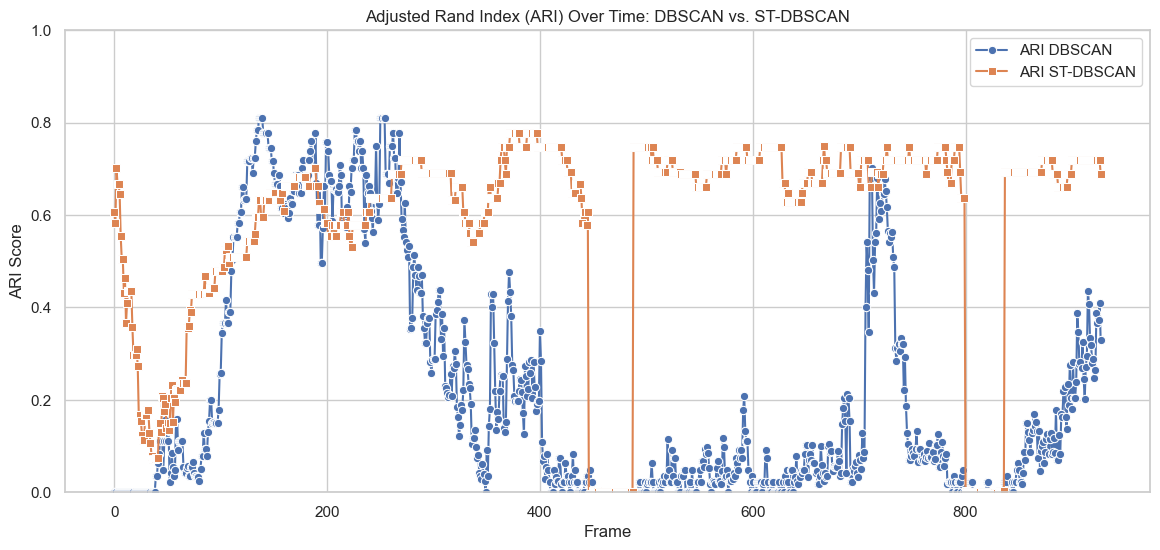

In [315]:
plt.figure(figsize=(14,6))
sns.lineplot(data=metrics_df_dbscan, x='frame', y='ARI_DBSCAN', label='ARI DBSCAN', marker='o')
sns.lineplot(data=metrics_df_st, x='frame', y='ARI_ST_DBSCAN', label='ARI ST-DBSCAN', marker='s')
plt.title('Adjusted Rand Index (ARI) Over Time: DBSCAN vs. ST-DBSCAN')
plt.xlabel('Frame')
plt.ylabel('ARI Score')
plt.ylim(0, 1)
plt.legend()
plt.show()


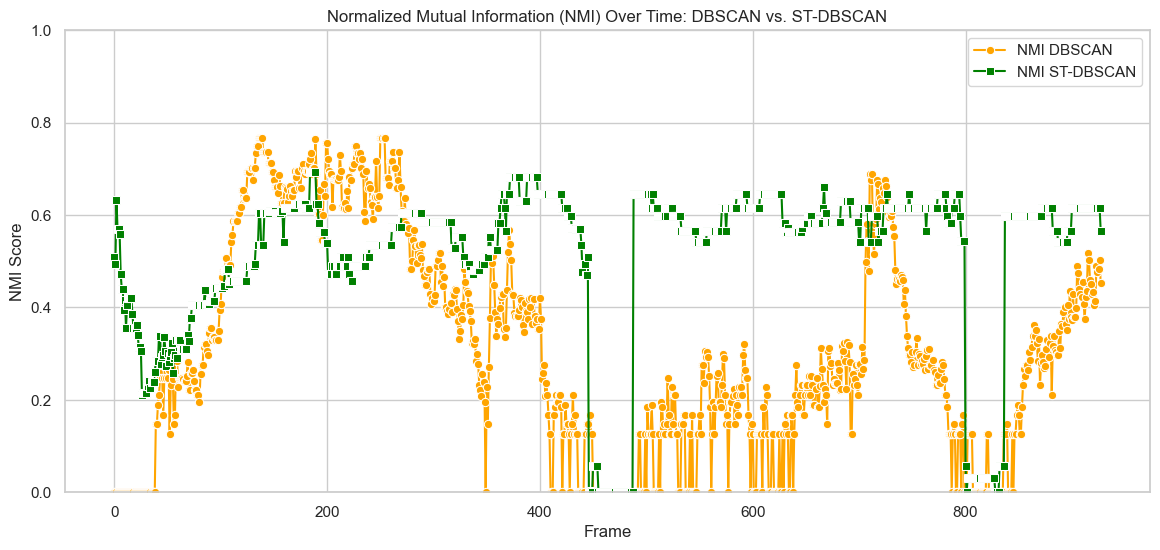

In [316]:
plt.figure(figsize=(14,6))
sns.lineplot(data=metrics_df_dbscan, x='frame', y='NMI_DBSCAN', label='NMI DBSCAN', color='orange', marker='o')
sns.lineplot(data=metrics_df_st, x='frame', y='NMI_ST_DBSCAN', label='NMI ST-DBSCAN', color='green', marker='s')
plt.title('Normalized Mutual Information (NMI) Over Time: DBSCAN vs. ST-DBSCAN')
plt.xlabel('Frame')
plt.ylabel('NMI Score')
plt.ylim(0, 1)
plt.legend()
plt.show()


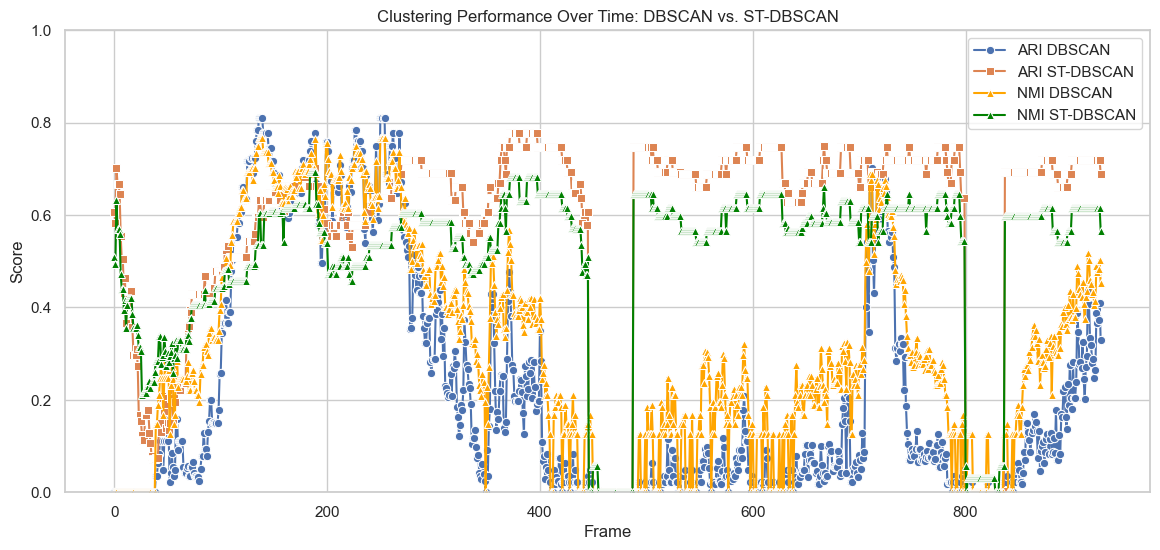

In [317]:
plt.figure(figsize=(14,6))
sns.lineplot(data=metrics_df_dbscan, x='frame', y='ARI_DBSCAN', label='ARI DBSCAN', marker='o')
sns.lineplot(data=metrics_df_st, x='frame', y='ARI_ST_DBSCAN', label='ARI ST-DBSCAN', marker='s')
sns.lineplot(data=metrics_df_dbscan, x='frame', y='NMI_DBSCAN', label='NMI DBSCAN', color='orange', marker='^')
sns.lineplot(data=metrics_df_st, x='frame', y='NMI_ST_DBSCAN', label='NMI ST-DBSCAN', color='green', marker='^')
plt.title('Clustering Performance Over Time: DBSCAN vs. ST-DBSCAN')
plt.xlabel('Frame')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend()
plt.show()


In [318]:
from scipy.stats import ttest_rel

# Perform paired t-test
t_stat, p_value = ttest_rel(metrics_df_dbscan['ARI_DBSCAN'], metrics_df_st['ARI_ST_DBSCAN'])
print(f"Paired t-test for ARI: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")


Paired t-test for ARI: t-statistic = -37.2968, p-value = 0.0000


In [319]:
# Perform paired t-test
t_stat, p_value = ttest_rel(metrics_df_dbscan['NMI_DBSCAN'], metrics_df_st['NMI_ST_DBSCAN'])
print(f"Paired t-test for NMI: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")


Paired t-test for NMI: t-statistic = -26.1714, p-value = 0.0000
